In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [180]:
# Start client for multiprocessing

from dask.distributed import Client

client = Client()#n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:43702 Dashboard: http://127.0.0.1:59023/status,Cluster Workers: 24 Cores: 24 Memory: 33.55 GB


In [6]:
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
from scipy import interpolate

stack_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/'

files = list(map(lambda x: stack_dir+x, list(filter(re.compile('S2').search, os.listdir(stack_dir)))))

data_alt_chunk = xr.open_mfdataset(files, chunks={'x':1000,'y':1000}, parallel=True)

In [237]:
def interpolate_band(da, int_dates):
    # Apply ufunc-- inputs xr.DataArray and dates for interpolation
    # returns data array with interpolated values for int_dates
    result = xr.apply_ufunc(ufunc_cubic_spline, da,
                            input_core_dims=[['time']],
                            output_core_dims=[['ntime']],
                            kwargs={'axis': -1,
                                    'orig_times': da.time.values,
                                    'new_times': int_dates},
                            dask='parallelized',
                            output_dtypes=[np.float32],
                            output_sizes={'ntime':int_dates.shape[0]})
    result['ntime'] = ('ntime', int_dates)
    return result

def ufunc_cubic_spline(a, axis, orig_times, new_times):
    """
    
    """
    # Reshape array to 2d (pixels, dates)
    data = a.reshape(-1, a.shape[-1])
    # Fit cubic spline and interpolate dates
    results = np.apply_along_axis(int_cubic_spline, 1, data,
                                  orig_times=orig_times,
                                  new_times=new_times)
    # Reshape to original pixels (y,x) and number of interpolated dates
    return results.reshape((a.shape[0],a.shape[1],new_times.shape[0]))

def int_cubic_spline(y, orig_times, new_times):
    """
    Cubic spline fitting and interpolation
    
    Args:
        y (np 1d-array): response to fit spline
        orig_times (np 1d-array): predictor to fit spline
        new_times (np 1d-array): points to interpolate
    
    Returns:
        interpolated (np 1d-array): interpolated values
    """
    # Filter NaNs in response
    nans = np.isnan(y)
    # Try to fit cubic spline with filtered y values
    
    
    try:
        spl = interpolate.CubicSpline(orig_times.astype('d')[~nans],
                                      y[~nans])
        
        interpolated = spl(new_times.astype('d'))
    
    except ValueError:
        ## When spline cannot be fitted(not enought data), return NaN
        ## TODO raise warning
        interpolated = np.empty(new_times.shape[0])
        interpolated[:] = np.nan
        
    return interpolated

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """http://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html"""
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def calculate_time_periods(ds, time_delta=16, date_of_analysis=None):
    """
    Defines date of analysis and calculates times periods for remote sensing image dates
    interpolation.
    
    Args:
        ds (xr.DataArray or xr.Dataset): the dataset or data array with remote sensing images
        time_delta (int): period of time between dates for interpolation
        date_of_analysis(np.datetime64): default last date in dataset minus time_delta
    
    Returns:
        date_of_analysis (np.datetime64): the date to perform the analysis
        
    """
    # Extract time from Dataset/DataArray
    times = ds.sortby('time').time.values
    last_time = times[-1]
    first_time = times[0]
        
    # List to append dates for interpolation
    dfi = []
       
    # Define default date of analysis
    if date_of_analysis is None:
        date_of_analysis = last_time - np.timedelta64(time_delta, 'D')
    # Time post-analysis
    time = date_of_analysis + np.timedelta64(time_delta, 'D')
    # Append times to list
    while time > first_time:
        dfi.append(time)
        time -= np.timedelta64(time_delta, 'D')
    
    return date_of_analysis, np.array(dfi, dtype=np.datetime64)


def prepare_dataset(dataset, location, bands=[]):
    
    dds = dataset.sortby('time').chunk({'time':-1,'x':100,'y':100}).persist()
    
    import dask
    from dask.diagnostics import ProgressBar
    
    output = []
    
    dof, times = calculate_time_periods(dds)
    
    for band in bands:    
        int_band = interpolate_band(dds[band], times)
        
        output.append(int_band.to_netcdf(location+band+'.nc', compute=False))
        
    with ProgressBar():
        dask.delayed(compute)(output)
    

In [240]:
import os
os.environ['WIN_SVR_DATA']

'/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/'

In [239]:
data_alt_chunk

<xarray.Dataset>
Dimensions:  (time: 8, x: 2979, y: 3631)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
    mask     (time, y, x) int8 dask.array<shape=(8, 3631, 2979), chunksize=(3, 1000, 1000)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir1    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir2    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    green    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    nir      (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    NDVI     (time, y, x) float32 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    LSWI     (time, y, x) 

In [228]:
rck = ndvi.where(ndvi.mask).chunk({'time':-1,'x':100,'y':100})
rck.persist()

<xarray.DataArray (time: 8, y: 3631, x: 2979)>
dask.array<shape=(8, 3631, 2979), dtype=float32, chunksize=(8, 100, 100)>
Coordinates:
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
    mask     (time, y, x) int8 dask.array<shape=(8, 3631, 2979), chunksize=(8, 100, 100)>
Attributes:
    crs:                       +init=epsg:32618
    header_offset:             0
    data_type:                 4
    nodatavals:                nan
    file_type:                 ENVI Standard
    res:                       [10. 10.]
    lines:                     3631
    transform:                 [ 4.8890e+05  1.0000e+01 -0.0000e+00  4.4846e+...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_18N",GEOGCS["GCS_WGS...
    interleave:                bsq
    is_tiled:                  0


In [229]:
dof, times = calculate_time_periods(rck)
print('Date of analysis is {}'.format(dof))
op = interpolate_band(rck, times)

Date of analysis is 2016-02-03T00:00:00.000000000


In [235]:
results = op.compute()

In [231]:
results

<xarray.DataArray (y: 3631, x: 2979, ntime: 5)>
array([[[0.838993, 0.763754, ..., 0.83337 , 0.884957],
        [0.782275, 0.715171, ..., 0.810143, 0.885762],
        ...,
        [0.297687, 0.227782, ..., 0.547984, 0.767415],
        [0.285584, 0.217948, ..., 0.483904, 0.719179]],

       [[0.841878, 0.781212, ..., 0.879744, 0.870084],
        [0.812725, 0.725621, ..., 0.852429, 0.850585],
        ...,
        [0.293675, 0.245591, ..., 0.53751 , 0.768037],
        [0.271797, 0.231722, ..., 0.501072, 0.716063]],

       ...,

       [[0.229021, 0.238874, ..., 0.369011, 0.58302 ],
        [0.228704, 0.234601, ..., 0.393621, 0.593012],
        ...,
        [0.421971, 0.355354, ..., 0.495428, 0.485169],
        [0.465702, 0.330411, ..., 0.569821, 0.54104 ]],

       [[0.207853, 0.22031 , ..., 0.33662 , 0.568585],
        [0.229512, 0.23549 , ..., 0.419191, 0.62993 ],
        ...,
        [0.408571, 0.352275, ..., 0.48937 , 0.483777],
        [0.440319, 0.333691, ..., 0.557876, 0.54213 ]]])

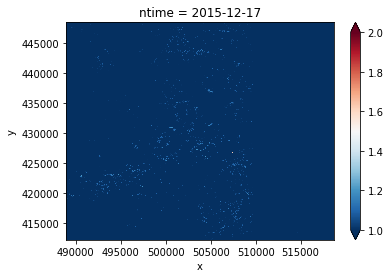

In [234]:
results.isel(ntime=-1).plot(vmin=1., vmax=2.,cmap='RdBu_r')

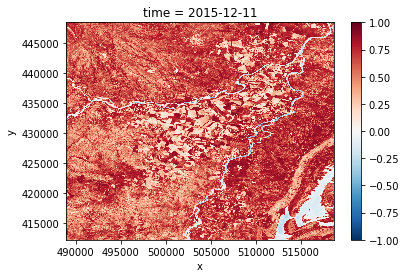

In [233]:
rck.isel(time=0).plot(vmin=-1., vmax=1.,cmap='RdBu_r')